### data1a - whole cars vs. all damaged cars

In [1]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [2]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is enabled)


In [3]:
def load_vgg16(weights_path='../vgg16_weights.h5'):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3, img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
      
    # assert os.path.exists(weights_path), 'Model weights not found (see "weights_path")'
    
    if weights_path:
    # note: this chops off the last layers of VGG16 

    # loads the weights of the VGG16 networks
    # note: when there is a complete match between model definition
    # and your weights savefile, you can simply call model.load_weights(filename)
        f = h5py.File(weights_path)
        for k in range(f.attrs['nb_layers']):
            if k >= len(model.layers): 
                # we don't look at the last (fully-connected) layers in the savefile
                break
            g = f['layer_{}'.format(k)]
            weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
            model.layers[k].set_weights(weights)
        f.close()
        print('VGG16 Model with partial weights loaded.')
    else:
        print('VGG16 Model with no weights Loaded.')

    return model

In [4]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = load_vgg16()
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16, 
                                            class_mode=None, 
                                            shuffle=False) 
    
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
    np.save(open(location+'/bottleneck_features_train.npy', 'w'), bottleneck_features_train)
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
    np.save(open(location+'/bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

In [5]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print "Best Model:" 
    print_best_model_results(hist)

In [6]:
def train_binary_model():

    train_data = np.load(open(location+'/bottleneck_features_train.npy'))
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(open(location+'/bottleneck_features_validation.npy'))
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu', W_regularizer=l2(0.01)))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation = 'sigmoid')) # should activation be sigmoid for binary problem?

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [7]:
def finetune_binary_model():
    model = load_vgg16()

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', W_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base
    model.add(top_model)
    
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False

    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    model.compile(loss='binary_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='binary')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
    # fine-tune the model
    fit = model.fit_generator(train_generator,
                              samples_per_epoch=nb_train_samples,
                              nb_epoch=nb_epoch,
                              validation_data=validation_generator,
                              nb_val_samples=nb_validation_samples,
                              verbose=1,
                              callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [8]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary', # categorical for multiclass
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    # use for multiclass
    # pred_labels = np.argmax(predictions, axis=1)
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print ''
    print classification_report(validation_labels, pred_labels)
    print ''
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='g');

In [9]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = raw_input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [10]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print 'epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_acc'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch]

## Testing Image Generation

In [32]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest') # omitted rescaling to keep the images displayable

img = load_img('data1a/training/00-damage/car_damage39.JPEG') # this is a PIL image 
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the 'preview/' directory
os.makedirs('data1a_preview')
i = 0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='data1a_preview', save_prefix='damage_car',
                         save_format='jpeg'):
    i +=1
    if i > 30:
        break # otherwise the generator would loop indefinitely

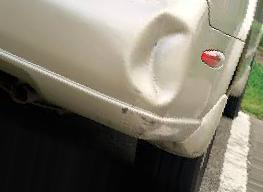

c to continue, q to quitq


'Finished for now.'

In [36]:
view_images('data1a_preview/', os.listdir('data1a_preview/'))

## Defining input data

In [11]:
# path to the model weights file
location = 'data1a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50

In [53]:
# do not rerun!!
save_bottleneck_features(location)

VGG16 Model with partial weights loaded.
Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [86]:
d1a_model1, d1a_history1 = train_binary_model()

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 1s - loss: 2.0218 - acc: 0.7489 - val_loss: 0.5771 - val_acc: 0.8348
Epoch 2/50
1840/1840 [==============================] - 1s - loss: 0.6036 - acc: 0.8299 - val_loss: 0.2331 - val_acc: 0.9152
Epoch 3/50
1840/1840 [==============================] - 1s - loss: 0.4686 - acc: 0.8467 - val_loss: 0.2335 - val_acc: 0.9087
Epoch 4/50
1840/1840 [==============================] - 1s - loss: 0.3682 - acc: 0.8701 - val_loss: 0.3974 - val_acc: 0.8826
Epoch 5/50
1840/1840 [==============================] - 1s - loss: 0.3475 - acc: 0.8891 - val_loss: 0.3642 - val_acc: 0.8739
Epoch 6/50
1840/1840 [==============================] - 1s - loss: 0.2433 - acc: 0.9201 - val_loss: 0.3008 - val_acc: 0.9174
Epoch 7/50
1840/1840 [==============================] - 1s - loss: 0.2465 - acc: 0.9185 - val_loss: 0.3784 - val_acc: 0.9000
Epoch 8/50
1840/1840 [==============================] - 1s - loss: 0.2274 - ac

In [134]:
d1a_model2, d1a_history2 = train_binary_model()

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 3s - loss: 6.2277 - acc: 0.5652 - val_loss: 0.3505 - val_acc: 0.8652
Epoch 2/50
1840/1840 [==============================] - 3s - loss: 1.8013 - acc: 0.7424 - val_loss: 0.9405 - val_acc: 0.7065
Epoch 3/50
1840/1840 [==============================] - 3s - loss: 1.4696 - acc: 0.7582 - val_loss: 0.5963 - val_acc: 0.8152
Epoch 4/50
1840/1840 [==============================] - 3s - loss: 1.5057 - acc: 0.7755 - val_loss: 1.2184 - val_acc: 0.7609
Epoch 5/50
1840/1840 [==============================] - 3s - loss: 1.5411 - acc: 0.7728 - val_loss: 1.4495 - val_acc: 0.6326
Epoch 6/50
1840/1840 [==============================] - 3s - loss: 1.2429 - acc: 0.7886 - val_loss: 0.4358 - val_acc: 0.8370
Epoch 7/50
1840/1840 [==============================] - 3s - loss: 1.0464 - acc: 0.7766 - val_loss: 0.2698 - val_acc: 0.9043
Epoch 8/50
1840/1840 [==============================] - 3s - loss: 1.1499 - ac

In [89]:
d1a_model3, d1a_history3 = train_binary_model() 

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 1s - loss: 2.2925 - acc: 0.6701 - val_loss: 0.3205 - val_acc: 0.8739
Epoch 2/50
1840/1840 [==============================] - 1s - loss: 0.5903 - acc: 0.8033 - val_loss: 0.2904 - val_acc: 0.9109
Epoch 3/50
1840/1840 [==============================] - 1s - loss: 0.4836 - acc: 0.8348 - val_loss: 0.3724 - val_acc: 0.8435
Epoch 4/50
1840/1840 [==============================] - 1s - loss: 0.3723 - acc: 0.8543 - val_loss: 0.2301 - val_acc: 0.9196
Epoch 5/50
1840/1840 [==============================] - 1s - loss: 0.3165 - acc: 0.8783 - val_loss: 0.2448 - val_acc: 0.9130
Epoch 6/50
1840/1840 [==============================] - 1s - loss: 0.3351 - acc: 0.8951 - val_loss: 0.3967 - val_acc: 0.8978
Epoch 7/50
1840/1840 [==============================] - 1s - loss: 0.2623 - acc: 0.9054 - val_loss: 0.4597 - val_acc: 0.8652
Epoch 8/50
1840/1840 [==============================] - 1s - loss: 0.2234 - ac

In [96]:
d1a_model4, d1a_history4 = train_binary_model() 

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 1s - loss: 7.7870 - acc: 0.4995 - val_loss: 5.9265 - val_acc: 0.5000
Epoch 2/50
1840/1840 [==============================] - 1s - loss: 2.4314 - acc: 0.7114 - val_loss: 0.3232 - val_acc: 0.8783
Epoch 3/50
1840/1840 [==============================] - 1s - loss: 0.6296 - acc: 0.7957 - val_loss: 0.3132 - val_acc: 0.8652
Epoch 4/50
1840/1840 [==============================] - 1s - loss: 0.5182 - acc: 0.8049 - val_loss: 0.2548 - val_acc: 0.9022
Epoch 5/50
1840/1840 [==============================] - 1s - loss: 0.4837 - acc: 0.8196 - val_loss: 0.2401 - val_acc: 0.9130
Epoch 6/50
1840/1840 [==============================] - 1s - loss: 0.4812 - acc: 0.8380 - val_loss: 0.2568 - val_acc: 0.9000
Epoch 7/50
1840/1840 [==============================] - 1s - loss: 0.4411 - acc: 0.8636 - val_loss: 0.2967 - val_acc: 0.8891
Epoch 8/50
1840/1840 [==============================] - 1s - loss: 0.4162 - ac

In [109]:
d1a_model5, d1a_history5 = train_binary_model() 

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 3s - loss: 8.1301 - acc: 0.4967 - val_loss: 1.4477 - val_acc: 0.5000
Epoch 2/50
1840/1840 [==============================] - 3s - loss: 1.0447 - acc: 0.7272 - val_loss: 0.2837 - val_acc: 0.8957
Epoch 3/50
1840/1840 [==============================] - 3s - loss: 0.8869 - acc: 0.7908 - val_loss: 0.9127 - val_acc: 0.7804
Epoch 4/50
1840/1840 [==============================] - 3s - loss: 1.0081 - acc: 0.8120 - val_loss: 1.0178 - val_acc: 0.7891
Epoch 5/50
1840/1840 [==============================] - 3s - loss: 0.8268 - acc: 0.8277 - val_loss: 0.2571 - val_acc: 0.9043
Epoch 6/50
1840/1840 [==============================] - 3s - loss: 0.8192 - acc: 0.8283 - val_loss: 0.4097 - val_acc: 0.9087
Epoch 7/50
1840/1840 [==============================] - 3s - loss: 0.7221 - acc: 0.8571 - val_loss: 0.2847 - val_acc: 0.8935
Epoch 8/50
1840/1840 [==============================] - 3s - loss: 0.6661 - ac

In [161]:
d1a_model6, d1a_history6 = train_binary_model() 

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 3s - loss: 5.6131 - acc: 0.7212 - val_loss: 0.3661 - val_acc: 0.8696
Epoch 2/50
1840/1840 [==============================] - 3s - loss: 5.4478 - acc: 0.8207 - val_loss: 0.3604 - val_acc: 0.8370
Epoch 3/50
1840/1840 [==============================] - 3s - loss: 5.3895 - acc: 0.8489 - val_loss: 0.3313 - val_acc: 0.8543
Epoch 4/50
1840/1840 [==============================] - 3s - loss: 5.3286 - acc: 0.8620 - val_loss: 0.2881 - val_acc: 0.8870
Epoch 5/50
1840/1840 [==============================] - 3s - loss: 5.2860 - acc: 0.8668 - val_loss: 0.2657 - val_acc: 0.9000
Epoch 6/50
1840/1840 [==============================] - 3s - loss: 5.2514 - acc: 0.8793 - val_loss: 0.2514 - val_acc: 0.9043
Epoch 7/50
1840/1840 [==============================] - 3s - loss: 5.2183 - acc: 0.8913 - val_loss: 0.2502 - val_acc: 0.9000
Epoch 8/50
1840/1840 [==============================] - 3s - loss: 5.1832 - ac

In [155]:
d1a_model7, d1a_history7 = train_binary_model()

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 3s - loss: 5.5925 - acc: 0.6962 - val_loss: 0.3607 - val_acc: 0.8609
Epoch 2/50
1840/1840 [==============================] - 3s - loss: 5.1508 - acc: 0.8293 - val_loss: 0.2857 - val_acc: 0.8826
Epoch 3/50
1840/1840 [==============================] - 3s - loss: 4.9166 - acc: 0.8435 - val_loss: 0.3312 - val_acc: 0.8543
Epoch 4/50
1840/1840 [==============================] - 3s - loss: 4.6991 - acc: 0.8598 - val_loss: 0.3208 - val_acc: 0.8652
Epoch 5/50
1840/1840 [==============================] - 3s - loss: 4.4773 - acc: 0.8772 - val_loss: 0.2563 - val_acc: 0.9043
Epoch 6/50
1840/1840 [==============================] - 3s - loss: 4.2693 - acc: 0.8788 - val_loss: 0.2845 - val_acc: 0.8783
Epoch 7/50
1840/1840 [==============================] - 3s - loss: 4.0890 - acc: 0.8875 - val_loss: 0.2632 - val_acc: 0.9065
Epoch 8/50
1840/1840 [==============================] - 3s - loss: 3.9314 - ac

Best Model:
epoch: 38 , val_acc: 0.930434782609 , val_loss: 0.717816673591


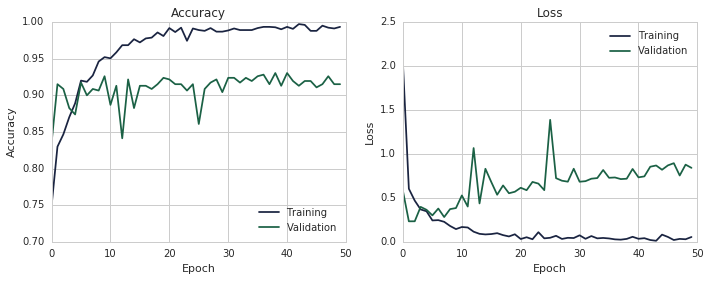

In [143]:
plot_metrics(d1a_history1) # rmsprop, sigmoid, no regularization

Best Model:
epoch: 18 , val_acc: 0.915217391304 , val_loss: 0.238060471399


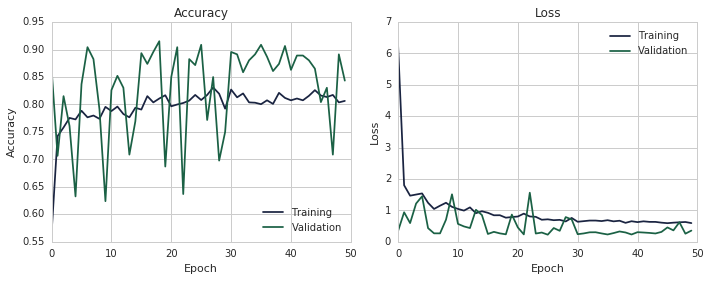

In [144]:
plot_metrics(d1a_history2) # rmsprop, sigmoid, with l2 regularization (0.01)

Best Model:
epoch: 13 , val_acc: 0.934782608696 , val_loss: 0.342017764477


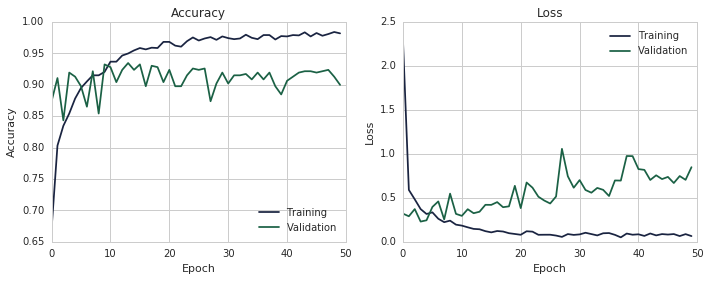

In [145]:
plot_metrics(d1a_history3) # rmsprop, sigmoid, with double dense and dropout layers

Best Model:
epoch: 26 , val_acc: 0.932608695652 , val_loss: 0.398729373393


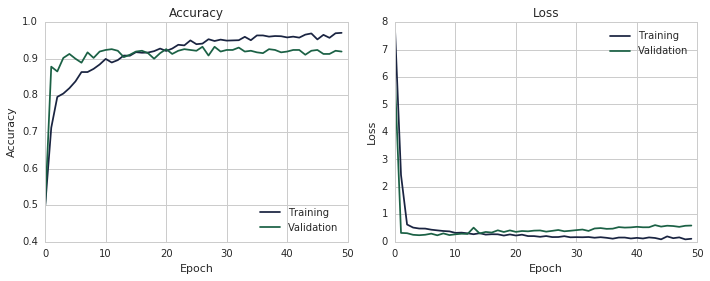

In [146]:
plot_metrics(d1a_history4) # rmsprop, sigmoid, with aggresive dropout (.75)

Best Model:
epoch: 19 , val_acc: 0.919565217391 , val_loss: 0.426407991819


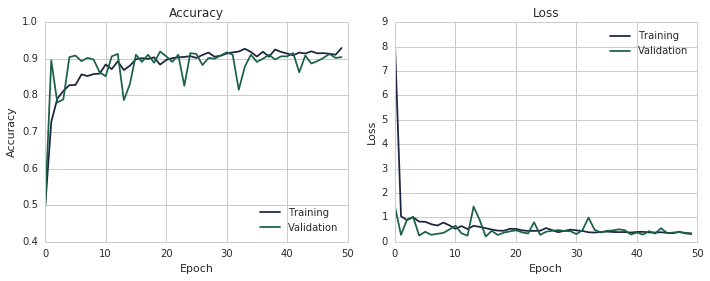

In [147]:
plot_metrics(d1a_history5) # rmsprop, sigmoid, with l2 = 0.001

Best Model:
epoch: 18 , val_acc: 0.923913043478 , val_loss: 0.227474954919


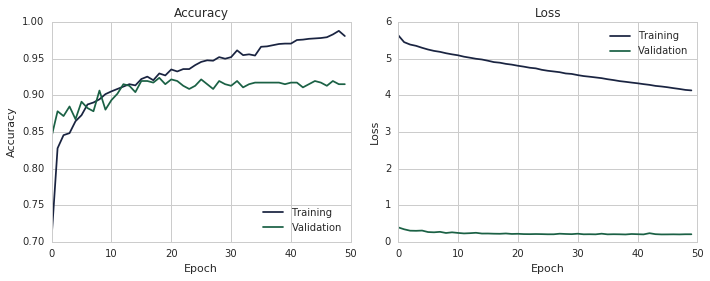

In [160]:
plot_metrics(d1a_history6) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

Best Model:
epoch: 47 , val_acc: 0.921739130435 , val_loss: 0.208093595116


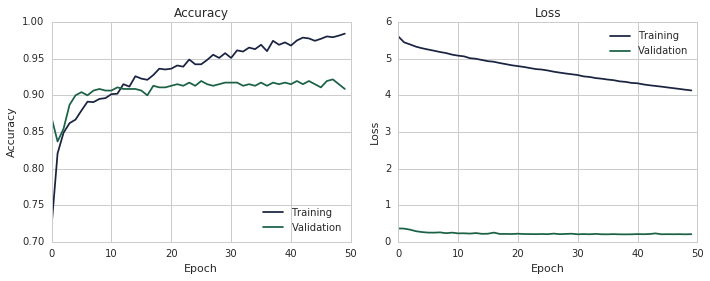

In [165]:
# WINNER
plot_metrics(d1a_history6) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

Best Model:
epoch: 9 , val_acc: 0.919565217391 , val_loss: 0.223592086201


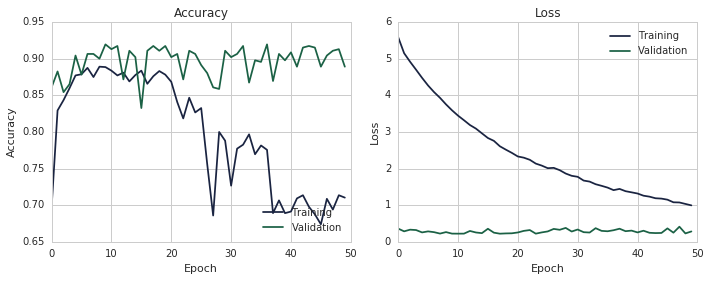

In [156]:
plot_metrics(d1a_history7) # sgd with lr = 0.001 and decay 1e-6, sigmoid, with l2 = 0.001

## Fine Tuning

In [175]:
ft_model, ft_history = finetune_binary_model()

VGG16 Model with partial weights loaded.
Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/50
1840/1840 [==============================] - 180s - loss: 4.5560 - acc: 0.7766 - val_loss: 0.3395 - val_acc: 0.8630
Epoch 2/50
1840/1840 [==============================] - 181s - loss: 4.4931 - acc: 0.8098 - val_loss: 0.2819 - val_acc: 0.8826
Epoch 3/50
1840/1840 [==============================] - 180s - loss: 4.4754 - acc: 0.8201 - val_loss: 0.3318 - val_acc: 0.8674
Epoch 4/50
1840/1840 [==============================] - 180s - loss: 4.4485 - acc: 0.8315 - val_loss: 0.3328 - val_acc: 0.8674
Epoch 5/50
1840/1840 [==============================] - 180s - loss: 4.4433 - acc: 0.8364 - val_loss: 0.2939 - val_acc: 0.8783
Epoch 6/50
1840/1840 [==============================] - 180s - loss: 4.4319 - acc: 0.8429 - val_loss: 0.3385 - val_acc: 0.8522
Epoch 7/50
1840/1840 [==============================] - 180s - loss: 4.4213 - acc: 0.8440 - val_loss: 0.2767 - val

Best Model:
epoch: 50 , val_acc: 0.917391304348 , val_loss: 0.207779218418


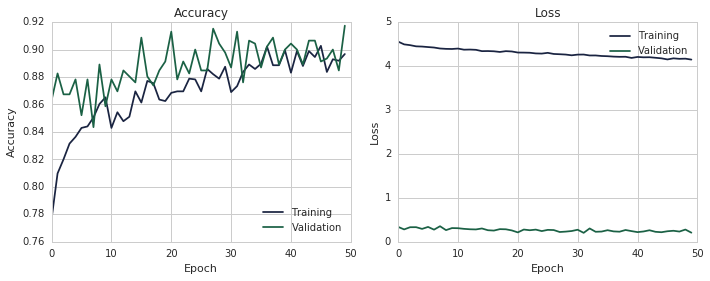

In [180]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

## Load Model Point

In [16]:
ft_model = load_model(location+'/ft_model.h5')

In [5]:
with open('data1a/top_history.txt') as f:    
    top_history = json.load(f)

In [6]:
with open('data1a/ft_history.txt') as f:    
    ft_history = json.load(f)

In [12]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print "Best Model:" 
    print_best_model_results(hist)

In [15]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [13]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary', # categorical for multiclass
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    # use for multiclass
    # pred_labels = np.argmax(predictions, axis=1)
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print ''
    print classification_report(validation_labels, pred_labels)
    print ''
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm 

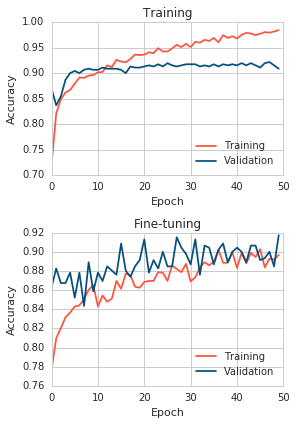

In [16]:
plot_acc_metrics(top_history, ft_history)

Best Model:
epoch: 50 , val_acc: 0.917391304348 , val_loss: 0.207779218418


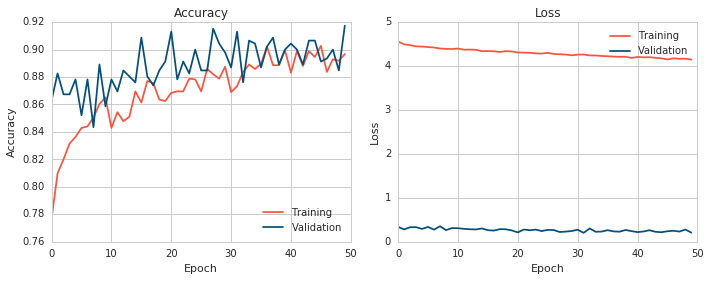

In [22]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [18]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1])

In [19]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

Found 460 images belonging to 2 classes.

             precision    recall  f1-score   support

          0       0.96      0.84      0.90       230
          1       0.86      0.96      0.91       230

avg / total       0.91      0.90      0.90       460




In [14]:
heatmap_labels = ['Damaged', 'Whole']

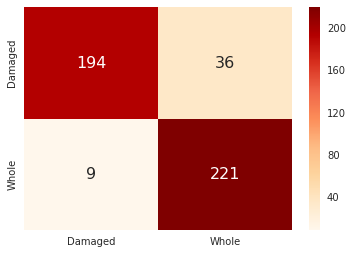

In [27]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

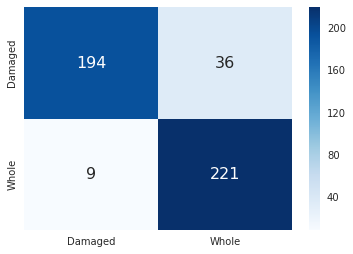

In [30]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [59]:
def car_categories_gate(image_path, model):
    urllib.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    print "Validating that damage exists..."
    print pred
    if pred[0][0] <=.5:

        print "Validation complete - proceed to location and severity determination"
    else:
        print "Are you sure that your car is damaged? Please submit another picture of the damage."
        print "Hint: Try zooming in/out, using a different angle or different lighting"

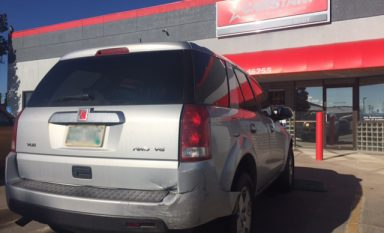

In [23]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [61]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

Validating that damage exists...
[[ 0.22355862]]
Validation complete - proceed to location and severity determination


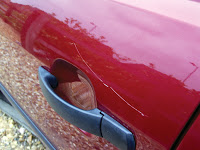

In [43]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [45]:
car_categories_gate('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

Validating that damage exists...
[[ 0.45193103]]


'Validation complete - proceed to location and severity determination'

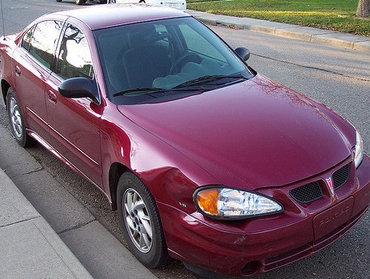

In [46]:
Image('https://www.carfax.com/media/zoo/images/rsz_frame-damage_85730e0a843d155e25e4b0f0e100bf65.jpg')

In [60]:
car_categories_gate('https://www.carfax.com/media/zoo/images/rsz_frame-damage_85730e0a843d155e25e4b0f0e100bf65.jpg', ft_model)

Validating that damage exists...
[[ 0.97538584]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


## Looking at edge cases

In [14]:
def get_edge_cases(model, directory, exp_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
        pred_prob = model.predict(x)
        if pred_prob <=0.5:
            pred = 0
        else:
            pred = 1
        if pred != exp_result:
            edge_list.append(name)
    return edge_list

Found 460 images belonging to 2 classes.

             precision    recall  f1-score   support

          0       0.96      0.84      0.90       230
          1       0.86      0.96      0.91       230

avg / total       0.91      0.90      0.90       460




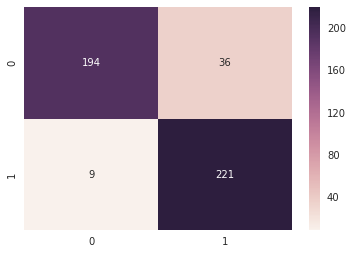

In [37]:
evaluate_binary_model(ft_model, validation_data_dir, validation_labels)
# TP = 221, TN = 194, FP = 36, FN = 9
# 9 were predicted to be damaged but were actually whole
# 36 were predicted to be whole but were actually damaged

In [17]:
fp = get_edge_cases(ft_model, 'data1a/validation/00-damage/', 0)

In [19]:
len(fp)

36

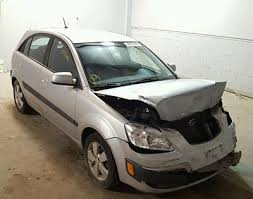

In [ ]:
view_images('data1a/validation/00-damage/', fp)  # damaged, identifed as whole

In [73]:
fn = get_edge_cases(ft_model, 'data1a/validation/01-whole/', 1)

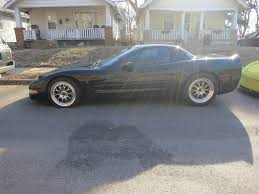

c to continue, q to quitq


'Finished for now.'

In [76]:
view_images('data1a/validation/01-whole/', fn) #whole, identified as damaged